In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import Compose, SamplePoints, NormalizeScale
from torch_geometric.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    

torch.__version__, device

('1.6.0+cu101', device(type='cuda'))

In [3]:
def visualize_mesh(pos, face):
    # from the tutorial https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U?usp=sharing#scrollTo=SvsEAR28LUI7
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(points, ax=None, show_grid=False):
    fig = plt.figure()
    if ax is None:
        ax = fig.gca(projection='3d')
    ax.patch.set_alpha(0)
    ax.grid(show_grid)
    ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,1], cmap='plasma', s=10)
    
    
def visualize_generated_samples(gen_samples, show_grid=False):
    fig = plt.figure(figsize=(16, 8))
    for i, gen_sample in enumerate(gen_samples):
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        visualize_points(gen_sample, ax, show_grid)

## Process the ModelNet data

ModelNet40(9843)
Data(face=[3, 104773], pos=[90714, 3], y=[1])


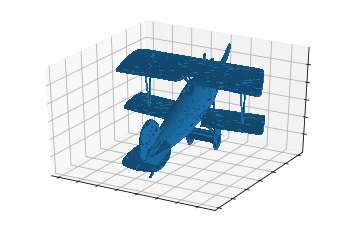

Data(face=[3, 17116], pos=[17443, 3], y=[1])


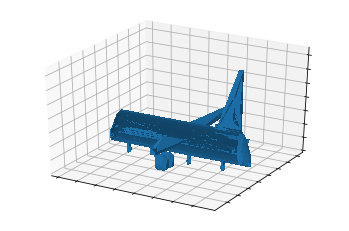

In [4]:
dataset = ModelNet(root='E:\data\modelnet40_data', name='40')
print(dataset)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

### Normalize the position scale and sample and plot points

In [5]:
torch.manual_seed(11)

n_points = 2048 # number of points to sample
dataset.transform = Compose([SamplePoints(num=n_points), NormalizeScale()])

Data(pos=[2048, 3], y=[1])
Data(pos=[2048, 3], y=[1])


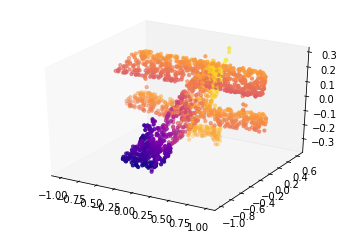

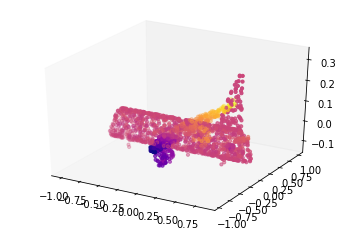

In [6]:
data = dataset[0]
print(data)
visualize_points(data.pos)

data = dataset[4]
print(data)
visualize_points(data.pos)

### Collect the data for a single class

In [7]:
shape_label = 2
single_class_data = dataset[dataset.data.y==shape_label]

In [8]:
n_shapes = len(single_class_data)
n_shapes

515

## Raw GAN (r-GAN)

(See https://arxiv.org/pdf/1707.02392.pdf)

**Generator**

Input  128 --->  Linear 64 + ReLU  ---> Linear 128 + ReLU ---> Linear 512 + ReLU --->  Linear 1024 + ReLU  --->  Linear 2048*3

<br></br>

**Discriminator**

Input 2048x3 --->

ENCODER

Conv1D (2048, 64, kernel_size=1)   + LeakyReLU  --->  
Conv1D (64, 128, kernel_size=1)    + LeakyReLU --->
Conv1D (128, 256, kernel_size=1)   + LeakyReLU  --->
Conv1D (256, 256, kernel_size=1)   + LeakyReLU  --->
Conv1D (256, 512, kernel_size=1)   + LeakyReLU  --->
(output.shape = (512, 3))

--->

DECODER 

--->  Linear(512, 128) + ReLU ---> Linear(128, 64) + ReLU --->
--->  Linear(64, 1) + Sigmoid ---> Fake or Real


In [9]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 512), nn.ReLU(True),
            nn.Linear(512, 1024), nn.ReLU(True),
            nn.Linear(1024, output_dim)
        )
    
    # TODO: try clipping the output to be in [-1, 1], e.g., by applying tanh
        
    def forward(self, x):
        # reshape to batch_size x 3 x n_points
        return self.model(x).view(x.size(0), 3, -1)

    
    def init_params(self, layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

In [10]:
# instantiate the r-GAN generator
raw_gan_gen_input_dim = 128
raw_gan_gen = Generator(raw_gan_gen_input_dim, n_points*3).to(device)

# initialize the parameters:
raw_gan_gen.apply(raw_gan_gen.init_params)

mu = 0.
sigma = 0.2

z = torch.FloatTensor(1, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)

print(z.shape)
print(raw_gan_gen(z).shape)

summary(raw_gan_gen, (1, raw_gan_gen_input_dim))

torch.Size([1, 128])
torch.Size([1, 3, 2048])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           8,256
              ReLU-2                [-1, 1, 64]               0
            Linear-3               [-1, 1, 128]           8,320
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 512]          66,048
              ReLU-6               [-1, 1, 512]               0
            Linear-7              [-1, 1, 1024]         525,312
              ReLU-8              [-1, 1, 1024]               0
            Linear-9              [-1, 1, 6144]       6,297,600
Total params: 6,905,536
Trainable params: 6,905,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 26.34
Estimated Total Size (MB

In [11]:
class Discriminator(nn.Module):
    def __init__(self, encoder_in_ch, encoder_out_ch):        
        super(Discriminator, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(encoder_in_ch, 64, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(256, 256, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(256, encoder_out_ch, 1, 1), nn.LeakyReLU(0.2)
        )
        # outputs (batch_size x encoder_out_ch x 3)
        # we then maxpool the output in the forward method, 
        # so the input to the decoder becomes (batch_size x encoder_out_ch)
        
        self.decoder = nn.Sequential(
            nn.Linear(encoder_out_ch, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, 1), nn.Sigmoid(),
        )
   

    def forward(self, x):
        x = self.encoder(x)
        x, _ = torch.max(x, dim=-1)
        x = self.decoder(x)
        return x
            
            
    def init_params(self, layer):
        if type(layer) == nn.Conv1d:
            nn.init.kaiming_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)            
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

In [12]:
# instantiate the r-GAN discriminator:
raw_gan_dis_input_ch = 3
raw_gan_dis = Discriminator(raw_gan_dis_input_ch, 512).to(device)

# initialize the parameters:
raw_gan_dis.apply(raw_gan_dis.init_params)

# print the summary:
y = torch.ones((1, 3, 2048)).to(device)
print(y.shape)

pred = raw_gan_dis(y)
print(pred.shape)

summary(raw_gan_dis, (raw_gan_dis_input_ch, 2048))

torch.Size([1, 3, 2048])
torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2048]             256
         LeakyReLU-2             [-1, 64, 2048]               0
            Conv1d-3            [-1, 128, 2048]           8,320
         LeakyReLU-4            [-1, 128, 2048]               0
            Conv1d-5            [-1, 256, 2048]          33,024
         LeakyReLU-6            [-1, 256, 2048]               0
            Conv1d-7            [-1, 256, 2048]          65,792
         LeakyReLU-8            [-1, 256, 2048]               0
            Conv1d-9            [-1, 512, 2048]         131,584
        LeakyReLU-10            [-1, 512, 2048]               0
           Linear-11                  [-1, 128]          65,664
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8

## Optimize the r-GAN

### Optimization setup

In [13]:
# hyperparameters:
lr_gen = 1e-5
lr_dis = 1e-4
beta1 = 0.5
beta2 = 0.999

# two separate optimizers for the generator and discriminator:
optimizer_gen = optim.Adam(params=raw_gan_gen.parameters(), 
                           lr=lr_gen, 
                           betas=(beta1, beta2))

optimizer_dis = optim.Adam(params=raw_gan_dis.parameters(), 
                           lr=lr_dis, 
                           betas=(beta1, beta2))

# by supplying with the correct labels, we will make it 
# equivalent to using non-saturating heuristic for the generator
# and the standard binary cross-entropy for the discriminator
criterion = nn.BCELoss().to(device)

### Create a dataloader for our single class dataset

In [14]:
batch_size = 50
dataloader = DataLoader(dataset=single_class_data, 
                        batch_size=batch_size, 
                        shuffle=True,
                        drop_last=True)

print('Batch size: ', batch_size)
print('Number of batches:', len(dataloader))

Batch size:  50
Number of batches: 10


### Training loop

In [15]:
epochs = 200
print_period = 10

losses_gen = []
losses_dis = []

for i in range(epochs):
    t0 = time.time()
    
    for batch_idx, batch_data in enumerate(dataloader):
        print(batch_idx, end='\r')
        batch_t0 = time.time()
        batch_size = batch_data.pos.shape[0] // n_points
        
        x = batch_data.pos.reshape(batch_size, n_points, 3).transpose(2, 1).to(device)
        
        # sample random vectors and generate samples from them:
        z = torch.FloatTensor(batch_size, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)
        gen_samples = raw_gan_gen(z)
        
        # get the discriminator output for the two types of input:
        prob_x = raw_gan_dis(x)
        prob_gen_samples = raw_gan_dis(gen_samples)
        
        # the target probabilities:
        prob_real = torch.ones((batch_size, 1)).to(device)
        prob_fake = torch.zeros((batch_size, 1)).to(device)
        
        # the non-saturating heuristic loss for the generator:
        loss_gen = criterion(prob_gen_samples, prob_real)
        
        # compute the gradient of the loss_gen wrt the generator parameters:
        optimizer_gen.zero_grad()
        loss_gen.backward(retain_graph=True)
        
        # update the generator parameters:
        optimizer_gen.step()
        losses_gen.append(loss_gen.item())
                
        # the usual (binary cross-entropy) loss for the discriminator:
        optimizer_dis.zero_grad()
        loss_dis_real_term = criterion(prob_x, prob_real)
        loss_dis_fake_term = criterion(prob_gen_samples.detach(), prob_fake)
        loss_dis = loss_dis_real_term + loss_dis_fake_term
        
        # compute the gradient and update the discriminator parameters:
        loss_dis.backward()
        optimizer_dis.step()
        losses_dis.append(loss_dis.item())
        
        if batch_idx % print_period == 0:
            print('ETA: %.5f, epoch: %d/%d, batch: %d/%d, loss_gen: %.3f, loss_dis: %.3f'
              % (time.time() - batch_t0, i+1, epochs, batch_idx, len(dataloader), torch.mean(torch.FloatTensor(losses_gen)), torch.mean(torch.FloatTensor(losses_dis)))
            )
            
    print('ETA: %.5f' % (time.time() - t0), end='\n\n')   

ETA: 0.67283, epoch: 1/200, batch: 0/10, loss_gen: 0.658, loss_dis: 0.924


RuntimeError: CUDA out of memory. Tried to allocate 200.00 MiB (GPU 0; 4.00 GiB total capacity; 2.33 GiB already allocated; 0 bytes free; 2.44 GiB reserved in total by PyTorch)

### Plot the losses

In [ ]:
def running_mean(data, periods=10):
    # from https://github.com/artemsavkin/latent3d/blob/master/pcl_latent3d_shapenet.ipynb
    weights = np.ones(periods) / periods
    return np.convolve(data, weights, mode='valid')

rm_losses_gen = running_mean(np.asarray(losses_gen))
rm_losses_dis = running_mean(np.asarray(losses_dis))


plt.plot(range(0, len(rm_losses_gen)), rm_losses_gen, 'r-', label='Generator')
plt.plot(range(0, len(rm_losses_dis)), rm_losses_dis, 'b-', label='Discriminator')
plt.gca().patch.set_alpha(0)
plt.title('r-GAN Losses')
plt.legend()
plt.show()

### Generate samples

In [ ]:
batch_idx, batch_data = next(enumerate(dataloader))
x = batch_data.pos.reshape(batch_size, n_points, 3).transpose(2, 1).cpu().detach().numpy()

# sample the noise vector:
z = torch.Tensor(4, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)
gen_samples = raw_gan_gen(z).cpu().detach().numpy()

print(x.shape)
print(gen_samples.shape)

visualize_generated_samples([x[0].transpose(1,0), gen_samples[0].transpose(1,0)])
# visualize_generated_samples([x[1].transpose(1,0), gen_samples[1].transpose(1,0)])
# visualize_generated_samples([x[2].transpose(1,0), gen_samples[2].transpose(1,0)])
# visualize_generated_samples([x[3].transpose(1,0), gen_samples[3].transpose(1,0)])